# Refactor `merge_operator_data`

In [25]:
import altair as alt
import merge_operator_data
import numpy as np
import pandas as pd
import yaml
from merge_data import PORTFOLIO_ORGANIZATIONS_DICT, merge_in_standardized_route_names
from segment_speed_utils import gtfs_schedule_wrangling, helpers, time_series_utils
from segment_speed_utils.project_vars import COMPILED_CACHED_VIEWS, PROJECT_CRS
from shared_utils import (
    catalog_utils,
    dask_utils,
    gtfs_utils_v2,
    portfolio_utils,
    publish_utils,
    rt_dates,
)
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS, SCHED_GCS, SEGMENT_GCS

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
analysis_date_list = rt_dates.y2024_dates

In [4]:
schedule_df = merge_operator_data.concatenate_schedule_operator_metrics(
    analysis_date_list
)

In [5]:
schedule_df.head(2)

,schedule_gtfs_dataset_key,operator_n_routes,operator_n_trips,operator_n_shapes,operator_n_stops,operator_n_arrivals,operator_route_length_miles,operator_arrivals_per_stop,n_downtown_local_routes,n_local_routes,n_coverage_routes,n_rapid_routes,n_express_routes,n_rail_routes,n_ferry_routes,name,organization_source_record_id,organization_name,service_date
0,0139b1253130b33adcd4b3a4490530d2,30,421,204,513,7985,612.87,15.57,0,0,32,27,0,0,0,TCRTA TripShot Schedule,rec4YWVqVwJ9XqDbq,Tulare County Regional Transit Agency,2024-01-17
1,0139b1253130b33adcd4b3a4490530d2,30,421,204,474,7885,612.16,16.64,0,0,32,27,0,0,0,TCRTA TripShot Schedule,rec4YWVqVwJ9XqDbq,Tulare County Regional Transit Agency,2024-02-14


In [6]:
rt_schedule_df = merge_operator_data.concatenate_rt_vs_schedule_operator_metrics(
    analysis_date_list
)

In [7]:
rt_schedule_df.head(2)

,schedule_gtfs_dataset_key,vp_per_min_agency,spatial_accuracy_agency,service_date
0,0139b1253130b33adcd4b3a4490530d2,2.52,67.36,2024-01-17
1,0139b1253130b33adcd4b3a4490530d2,2.59,59.87,2024-02-14


In [8]:
gdf = merge_operator_data.concatenate_operator_routes(analysis_date_list).pipe(
    merge_data.merge_in_standardized_route_names
)

### Task #1: Aggregate `crosswalk` to `portfolio_organization_name`
* <i>Group by name-service_date-portfolio_organization_name to aggregate up to      portfolio_organization_name,because name indicates different feeds, so we want to sum those</i>. 
* AH: How do we account for situations when the different `organization_names` have different hq_cities, reporter_types, etc -> see Ventura County. we use these fields in this part of the portfolio. 
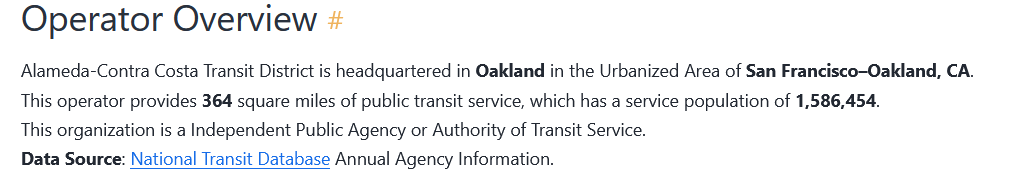

In [10]:
crosswalk_df = merge_operator_data.concatenate_crosswalks(analysis_date_list)

In [11]:
crosswalk_df.head(1)

,service_date,caltrans_district,portfolio_organization_name,schedule_gtfs_dataset_key,name,hq_city,organization_type,primary_uza_name,reporter_type,service_area_pop,service_area_sq_miles
0,2024-01-17,02 - Redding,Redding Area Bus Authority,91af7482fde58c6261f386b732404e11,Redding Schedule,Redding,"City, County or Local Government Unit or Department of Transportation","Redding, CA",Rural Reporter,0,0


In [12]:
crosswalk_df.portfolio_organization_name.nunique(), len(
    crosswalk_df
), crosswalk_df.name.nunique()

(108, 1336, 119)

In [13]:
crosswalk_df.loc[crosswalk_df.service_date == "2024-01-17"].shape

(109, 11)

In [19]:
crosswalk_df.loc[crosswalk_df.service_date == "2024-01-17"][
    "portfolio_organization_name"
].nunique()

97

In [23]:
crosswalk_df.loc[
    (crosswalk_df.service_date == "2024-01-17")
    & (
        crosswalk_df.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

,service_date,caltrans_district,portfolio_organization_name,schedule_gtfs_dataset_key,name,hq_city,organization_type,primary_uza_name,reporter_type,service_area_pop,service_area_sq_miles
81,2024-01-17,07 - Los Angeles / Ventura,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,Camarillo,"City, County or Local Government Unit or Department of Transportation","Camarillo, CA",Reduced Reporter,68374,20
82,2024-01-17,07 - Los Angeles / Ventura,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,Camarillo,Independent Public Agency or Authority of Transit Service,"Oxnard--San Buenaventura (Ventura), CA",Full Reporter,209877,28
83,2024-01-17,07 - Los Angeles / Ventura,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,Moorpark,"City, County or Local Government Unit or Department of Transportation","Thousand Oaks, CA",Reduced Reporter,35975,12
84,2024-01-17,07 - Los Angeles / Ventura,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,Oxnard,Independent Public Agency or Authority of Transit Service,"Oxnard--San Buenaventura (Ventura), CA",Full Reporter,374827,84
85,2024-01-17,07 - Los Angeles / Ventura,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,Simi Valley,"City, County or Local Government Unit or Department of Transportation","Simi Valley, CA",Reduced Reporter,126356,50
86,2024-01-17,07 - Los Angeles / Ventura,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,Thousand Oaks,"City, County or Local Government Unit or Department of Transportation","Thousand Oaks, CA",Reduced Reporter,420862,167


In [15]:
operator_df = merge_operator_data.merge_data_sources_by_operator(
    schedule_df, rt_schedule_df, crosswalk_df
)

In [16]:
operator_df.head(1)

,schedule_gtfs_dataset_key,operator_n_routes,operator_n_trips,operator_n_shapes,operator_n_stops,operator_n_arrivals,operator_route_length_miles,operator_arrivals_per_stop,n_downtown_local_routes,n_local_routes,n_coverage_routes,n_rapid_routes,n_express_routes,n_rail_routes,n_ferry_routes,name,organization_source_record_id,organization_name,service_date,vp_per_min_agency,spatial_accuracy_agency,caltrans_district,portfolio_organization_name,hq_city,organization_type,primary_uza_name,reporter_type,service_area_pop,service_area_sq_miles
0,0139b1253130b33adcd4b3a4490530d2,30,421,204,513,7985,612.87,15.57,0,0,32,27,0,0,0,TCRTA TripShot Schedule,rec4YWVqVwJ9XqDbq,Tulare County Regional Transit Agency,2024-01-17,2.52,67.36,06 - Fresno / Bakersfield,Tulare County Regional Transit Agency,Visalia,Independent Public Agency or Authority of Transit Service,"Tulare, CA",Full Reporter,473117,4839


### Task #2: 
* Is there a short/long route, can it be flagged per date as a new column here?

In [26]:
# Need to add portfolio_organization_name
gdf = gdf.pipe(
    portfolio_utils.standardize_portfolio_organization_names,
    PORTFOLIO_ORGANIZATIONS_DICT,
)

In [37]:
gdf.columns

Index(['shape_array_key', 'geometry', 'feed_key', 'schedule_gtfs_dataset_key',
       'route_id', 'direction_id', 'route_key', 'route_length',
       'route_length_miles', 'is_downtown_local', 'is_local', 'is_coverage',
       'is_rapid', 'is_express', 'is_rail', 'is_ferry',
       'organization_source_record_id', 'organization_name', 'service_date',
       'name', 'combined_name', 'recent_combined_name', 'recent_route_id',
       'portfolio_organization_name'],
      dtype='object')

In [38]:
gdf_subset = gdf[
    ["route_id", "route_length_miles", "service_date", "portfolio_organization_name"]
]

In [39]:
def find_percentiles(df: pd.DataFrame, col_of_interest: str) -> pd.DataFrame:
    """
    Take a column you're interested in and categorize it by row
    for each percentile group it belongs to.
    """
    # Get percentiles in objects for total vehicle.
    p25 = df[col_of_interest].quantile(0.25).astype(float)
    p50 = df[col_of_interest].quantile(0.50).astype(float)
    p75 = df[col_of_interest].quantile(0.75).astype(float)

    # Make a dataframe out of this
    percentile_data = {
        f"{col_of_interest}_percentile": [
            "25th percentile",
            "50th percentile",
            "< 75th percentile",
            "> 75th percentile",
        ],
        "percentile_group": [
            f"25 percentile (<={p25.astype(int)} miles)",
            f"26-50th percentile ({p25.astype(int) + 0.1}-{p50.astype(int)} miles)",
            f"51-75th percentile ({p50.astype(int) + 0.1}-{p75.astype(int)} miles)",
            f"76th percentile (>={p75.astype(int) + 0.1} miles)",
        ],
    }
    percentile_df = pd.DataFrame(data=percentile_data)

    def categorize_percentile(row):
        if (row[col_of_interest] > 0) and (row[col_of_interest] <= p25):
            return "25th percentile"
        elif (row[col_of_interest] > p25) and (row[col_of_interest] <= p50):
            return "50th percentile"
        elif (row[col_of_interest] > p50) and (row[col_of_interest] <= p75):
            return "< 75th percentile"
        elif row[col_of_interest] > p75:
            return "> 75th percentile"
        else:
            return "Zero"

    # Actually categorize each value for percentile
    df[f"{col_of_interest}_percentile"] = df.apply(
        lambda x: categorize_percentile(x), axis=1
    )

    # Delete out routes w/o service mile info
    df = df.loc[df[f"{col_of_interest}_percentile"] != "Zero"]

    # Merge the dataframes
    df2 = pd.merge(df, percentile_df, on=f"{col_of_interest}_percentile")
    return df2

### Task #3:
* <i>take input produced in concatenate_operator_routes
    get counties for operator-date
    df should only be operator-date-counties_served
    use this to merge into crosswalk and replace NTD column</i>

In [41]:
gdf_subset2 = gdf[
    ["route_id", "service_date", "portfolio_organization_name", "geometry"]
]

In [46]:
import geopandas as gpd
from calitp_data_analysis.sql import to_snakecase

In [44]:
def get_counties()->gpd.GeoDataFrame:
    """
    Load a geodataframe of the California counties.
    """
    ca_gdf = "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
    my_gdf = to_snakecase(gpd.read_file(f"{ca_gdf}"))[["county_name", "geometry"]]

    return my_gdf

In [47]:
ca_counties = get_counties()

In [48]:
counties_served = gpd.sjoin(
    gdf_subset2,
    ca_counties.to_crs(gdf.crs),
    how="inner",
    predicate="intersects").drop(columns="index_right")

In [50]:
counties_served2 = (counties_served[["portfolio_organization_name","county_name"]]
                       .drop_duplicates()
                       .sort_values(by = ["county_name"])
                       .reset_index(drop = True)
                      )

In [53]:
counties_served2.head(1)

,portfolio_organization_name,service_date,county_name
0,San Joaquin Regional Rail Commission,2024-12-11,Alameda


In [51]:
counties_served3 = counties_served2.T

In [54]:
def concat_all_columns(df: pd.DataFrame)->pd.DataFrame:
    """ 
    Concatenate all columns into a new column called 'all'
    """
    df['all'] = df.apply(lambda row: ', '.join(row.astype(str)), axis=1)

    return df

In [55]:
counties_served4 = concat_all_columns(counties_served3)